In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
import qiskit as qiskit
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
# Loading your IBM Quantum account(s)
IBMQ.save_account(
    '280beccbee94456a161a6cbc217e1366bc278bf60e22bd30281fa0ca5bec6e50897278ef818f3c53f6700e04b9ed32ea364195044413b7e02836a79d886b03d9',
    overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')

C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\user\AppData\Local\Temp\ipykernel_21384\1018955272.py:11: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.save_account(
C:\Users\user\AppData\Local\Temp\ipykernel_21384\1018955272.py:11: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-i

In [2]:
h = lambda n, J, z: sum([J[i] * (z[i] - 1) * (z[(i + 1)%n] - 1) for i in range(n)])

def effective_hem(size, J):
    hem = np.zeros((2**size, 2**size))
    for i in range(2**size):
        binary = '{0:b}'.format(i).zfill(size)
        Z = [(-1)**int(i) for i in binary]
        hem[i,i] = h(size, J, Z)
    return hem

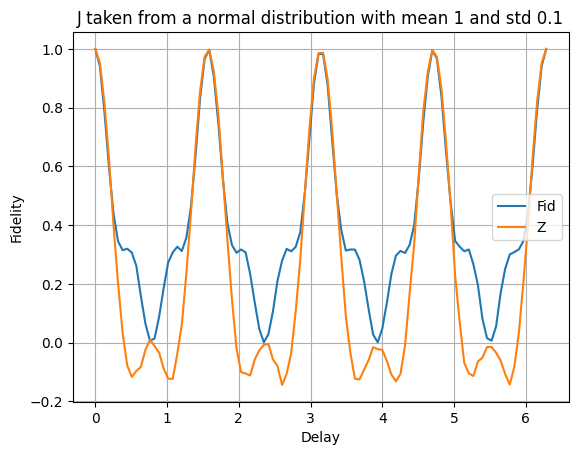

In [4]:
from scipy.linalg import expm
import random
res = []
delay = np.linspace(0,2*np.pi,100)
n = 3
shots = 6000
fid = []
Z = []
Zi = [[] for _ in range(n)] # Create a list of lists to store the expectation values for each qubit

J = [random.gauss(1, 0) for _ in range(n)]
#J = [0.8, np.sqrt(3)]
for t in delay:
    #qr = QuantumRegister(n)
    #cr = ClassicalRegister(n)
    qc = QuantumCircuit(n)
    for i in range(n):
        qc.h(i)

    U = expm((-1j*t)*effective_hem(n,J))
    U = qi.Operator(U)

    qc.unitary(U, [i for i in range(n)])

    for i in range(n):
        qc.h(i)
    qc.measure_all()
    #qc.measure(qr[1],cr[1])

    #Simulator
    qcomp = Aer.get_backend("qasm_simulator")
    result = qiskit.execute(qc, Aer.get_backend('qasm_simulator'), shots=shots).result()
    fid.append(result.get_counts().get('0'*n,0)/shots)
    res.append(result.get_counts())

    # z_expectation_value = 0
    # for outcome, count in result.get_counts().items():
    #     # Calculate parity (1 for even parity, -1 for odd parity)
    #     parity = (-1) ** outcome.count('1')
    #     probability = count / sum(result.get_counts().values())
    #     z_expectation_value += parity * probability
    # Z.append(z_expectation_value)

    #Calculate Zi expectation value
    Zi = []
    for i in range(n):
        for outcome, count in result.get_counts().items():
            plus = [count if outcome[i] == '0' else 0]
            minus = [count if outcome[i] == '1' else 0]
            Zi.append((sum(plus) - sum(minus))/sum(result.get_counts().values()))

    Z.append(sum(Zi)/n)
#print(Zi[0])

plt.grid()
plt.ylabel('Fidelity')
plt.xlabel('Delay')
plt.title('J taken from a normal distribution with mean 1 and std 0.1')
plt.plot(delay,fid, label = 'Fid')
plt.plot(delay,Z, label = 'Z')
plt.legend()

[1.1534757376439846, 1.172514226505238]
0.7615982190520711


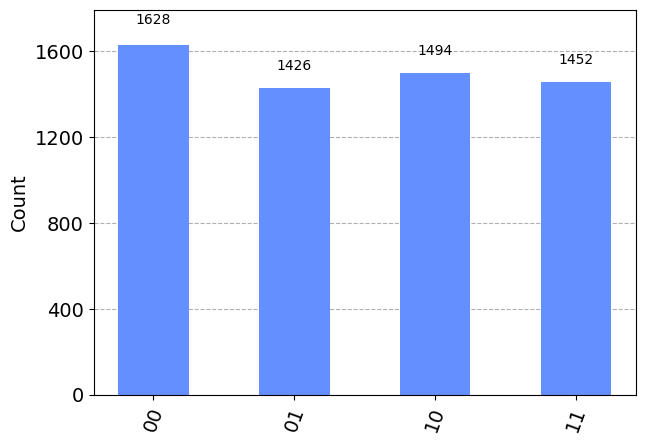

In [21]:
#Plots qiskit histogram:
print(J)
print(delay[12])
t = delay[6]
from qiskit.visualization import plot_histogram
plot_histogram(res[12])


In [22]:
from imp import reload
import CalculateCrossTalk
reload(CalculateCrossTalk)
print(CalculateCrossTalk.one_dim(t,res[6], n))



480.6666666666667
[1.98152528 0.99666601]


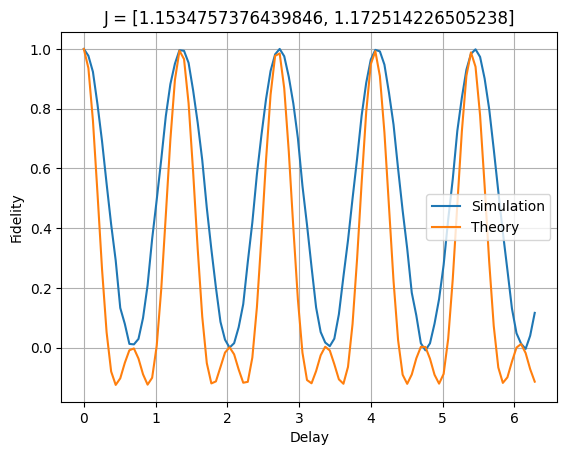

In [23]:
def func(J, t):
    n = len(J)
    result = n
    for i in range(n):
        result += 2*np.cos(4 * J[i] * t)
    for i in range(n):
        result += np.cos(4 * (J[i] + J[(i+1)%n]) * t)
    return result/(2*(2*n))


Y = [func(J,t) for t in delay]
plt.grid()
plt.ylabel('Fidelity')
plt.xlabel('Delay')
plt.title(f'J = {J}')
plt.plot(delay,Z, label = 'Simulation')
plt.plot(delay,Y, label = 'Theory')
plt.legend()

Fitted coefficients:  [1.13781557 1.16001941]


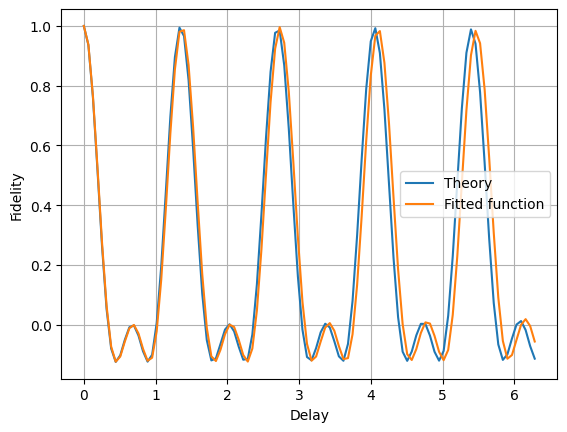

In [24]:
from scipy.optimize import curve_fit

#Define the function that you want to fit.
def func(t, *js):
    n = len(js)
    result = n
    for i in range(n):
        result += 2*np.cos(4 * js[i] * t)
    for i in range(n):
        result += np.cos(4 * (js[i] + js[(i+1)%n]) * t)
    return result/(2*(2*n))


# Initial guess for js
# Here I'm assuming that js is a list of the same size as delay.
# If that's not the case, you should provide an appropriate initial guess.
initial_js = np.ones(n)

# Fit your function to the data
popt, pcov = curve_fit(func, delay, Z, p0=initial_js, bounds=(0,2))

# Print the coefficients
print("Fitted coefficients: ", popt)

# Generate Y values for the fitted function
Y_fitted = [func(t, *popt) for t in delay]

# Plot the data, the original function, and the fitted function
plt.grid()
plt.ylabel('Fidelity')
plt.xlabel('Delay')
#plt.plot(delay, Z, label='Qiskit')
plt.plot(delay, Y, label='Theory')
plt.plot(delay, Y_fitted, label='Fitted function')
plt.legend()


In [25]:
print(CalculateCrossTalk.crosstalk_operator(4, 1))

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 exp(-4.0*I*J3) 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 exp(-4.0*I*J2) 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 exp(1.0*I*(-4*J2 - 4*J3)) 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 exp(-4.0*I*J4) 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 exp(1.0*I*(-4*J3 - 4*J4)) 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 exp(-4.0*I*J1) 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 exp(1.0*I*(-4*J1 - 4*J4)) 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 exp(1.0*I*(-4*J1 - 4*J2)) 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 exp(1.0*I*(-4*J1 - 4*J2 - 4*J3 - 4*J4))]]
